Declaration A

Start by importing bbSearch to perform search algorithms

In [2]:
!echo Installing bbSearch module from web ...
!echo creating bbmodcache subfolder
!mkdir -p bbmodcache
!echo downloading bbSearch module
!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py

from bbmodcache.bbSearch import SearchProblem, search

Installing bbSearch module from web ...
creating bbmodcache subfolder
downloading bbSearch module
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18767  100 18767    0     0   305k      0 --:--:-- --:--:-- --:--:--  305k
Loading bbSearch Version 2.1 (at 10:03, Tue 18 Feb)
Last module source code edit 9am Thursday 24th Feb 2022


Code from Search exercise 7. Creates the grids with their respective blocks and their respective colours

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy

plt.ioff()  ## Turn off immediate display of plots

COLORS = ["lightgray", "red", "blue", "green", "yellow",
          "orange", "purple", "pink", "brown"]

class BlockState:

      # Specify mapping from directions to grid coordinate offsets:
      neighbour_offset = {"left": (0,-1), "right": (0,+1), "down":(+1,0), "up":(-1,0)}

      def __init__( self, blockstate, colors=COLORS ):
        self.blockstate = blockstate
        self.nrows = len(blockstate)
        self.ncols = len(blockstate[0])
        self.blocknums = set().union(*[set(row) for row in blockstate])
        self.blocknums = self.blocknums - {0}
        self.blocknumlist = list(self.blocknums)
        self.colors = colors

      def __repr__(self):
        return( str( self.blockstate ))

      # Find the cells occupied by a given number
      def blockcells( self, blocknum ):
          blockcells = []
          for row in range(self.nrows):
            for col in range(self.ncols):
              if self.blockstate[row][col] == blocknum:
                blockcells.append((row,col))
          return blockcells

      # Test if a cell is free (unblocked) in a given direction
      # Free if not blocked by edge of grid or by a cell of different colour
      def free_cell( self, direction, cell ):
        row, col = cell
        offrow, offcol = BlockState.neighbour_offset[direction]
        neighrow, neighcol = (row + offrow, col + offcol)
        if not (0 <= neighrow < self.nrows): return False #at top or bottom
        if not (0 <= neighcol < self.ncols): return False #at left or right
        neighval = self.blockstate[neighrow][neighcol]
        # Neighboring cell must be empty or part of the same coloured block
        return  (neighval==0 or neighval==self.blockstate[row][col])

      def free_block( self, direction, blockn ):
          blockcells = self.blockcells(blockn)
          for cell in blockcells:
            if not self.free_cell(direction, cell):
              return False
          return True

      def possible_moves(self):
        moves = []
        for blocknum in self.blocknumlist:
          for direction in ["left", "right", "down", "up"]:
              if self.free_block(direction, blocknum):
                  moves.append((blocknum, direction))
        return moves

      def next_state(self, move):
          next_blockstate = deepcopy(self.blockstate)
          blockno, direction = move
          cells = self.blockcells(blockno)
          ## first clear all cells of the block (set to 0)
          for cell in cells:
            row, col = cell
            next_blockstate[row][col] = 0
          rowoff, coloff = BlockState.neighbour_offset[direction]
          ## now set all neighbour cells (in move direction) to be
          ## cells with the blocknumber
          for cell in cells:
            row, col = cell
            next_blockstate[row+rowoff][col+coloff] = blockno
          return BlockState(next_blockstate)

      def color_key(self):
          return {b:self.colors[b] for b in self.blocknumlist}

      def figure(self, scale=0.5):
          nrows = self.nrows
          ncols = self.ncols
          fig, ax = plt.subplots(figsize=(ncols*scale+0.1,nrows*scale+0.1))
          plt.close(fig)
          ax.set_axis_off() # Don't show border lines and coordinate values

          frame = patches.Rectangle((0,0),1,1, linewidth=5, edgecolor='k', facecolor='w')
          ax.add_patch(frame)

          for row in range(nrows):
            for col in range(ncols):
                greyrect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                               (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=1, edgecolor="gray", facecolor="lightgray")
                ax.add_patch(greyrect)

          for row in range(nrows):
            for col in range(ncols):
                cellval = self.blockstate[row][col]
                if cellval > 0:
                  cellcol = COLORS[cellval]
                  rect = patches.Rectangle( (((col*0.9)/ncols)+0.05,
                                             (((nrows-row-1)*0.9)/nrows)+0.05 ),
                                            0.9/ncols, 0.9/nrows,
                                            linewidth=0, edgecolor=cellcol, facecolor=cellcol)
                  ax.add_patch(rect)
          return fig

      def display(self):
          display(self.figure())

In [4]:
from copy import deepcopy
class SlidingBlocksPuzzle( SearchProblem ):

    def __init__( self, initial_state, goal, colors=COLORS ):
        """
        The __init__ method must set the initial state for the search.
        Arguments could be added to __init__ and used to configure the
        initial state and/or other aspects of a problem instance.
        """
        self.initial_state = BlockState(initial_state, colors=colors)
        self.colors = colors
        self.goal = BlockState(goal)

    def info(self):
        print("Solve the following sliding blocks problem.")
        print("Get from this initial state:")
        self.initial_state.display()
        print("To a state incorporating the following block position(s):")
        self.goal.display()
        print("You need to slide the red block to cover the bottom right square.")

    def possible_actions(self, state):
        return state.possible_moves()

    def successor(self, state, action):
        """
        This takes a state and an action and returns the new state resulting
        from doing that action in that state. You can assume that the given
        action is in the list of 'possible_actions' for that state.
        """
        return state.next_state(action)

    def goal_test(self, state):
        """
        For the sliding blocks puzzles, the goal condition is reached when
        all block possitions specified in the given goal state are satisfied by
        the current state. But empty positions (ie 0s) in the goal are ignored,
        so can be occupied by blocks in the current sate.
        """
        for row in range(state.nrows):
          for col in range(state.ncols):
            goalnum = self.goal.blockstate[row][col]
            if goalnum==0:
              continue
            if goalnum != state.blockstate[row][col]:
              return False
        return True


    def cost(self, path, state):
        """
        This is an optional method that you only need to define if you are using
        a cost based algorithm such as "uniform cost" or "A*". It should return
        the cost of reaching a given state via a given path.
        If this is not re-defined, it will is assumed that each action costs one unit
        of effort to perform, so it returns the length of the path.
        """
        return len(path)

    def display_action(self, action):
        """
        You can set the way an action will be displayed in outputs.
        """
        print((self.colors[action[0]], action[1]))

    def display_state(self, state):
        """
        You can set the way a state will be displayed in outputs.
        """
        state.display()

    def display_state_path( self, actions ):
        """
        This defines output of a solution path when a list of actions
        is applied to the initial state. It assumes it is a valid path
        with all actions being possible in the preceeding state.
        You probably don't need to override this.
        """
        s = self.initial_state
        self.display_state(s)
        for a in actions:
            self.display_action(a)
            s = self.successor(s,a)
            self.display_state(s)

After some experimentation we decided to investigate the following cases of Sliding Block Puzzle. We chose a 4x4 grid for the smaller grid as well as an 7x6 grid for the second, larger grid. We placed the same blocks on both grids and the goal for both is to move the red L chaped block to the bottom left of both grid. 

In [5]:
small_initial = [[1,0,0,2],
         [1,1,0,0],
         [0,0,0,4],
         [3,3,0,4]]

small_goal = [[0,0,0,0],
         [0,0,0,0],
         [0,0,1,0],
         [0,0,1,1]]

large_initial = [[1,0,0,0,0,0,2],
         [1,1,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,4],
         [3,3,0,0,0,0,4]]


large_goal = [[0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0],
         [0,0,0,0,0,1,0],
         [0,0,0,0,0,1,1]]

small_puzzle =  SlidingBlocksPuzzle( small_initial,  small_goal)
large_puzzle =  SlidingBlocksPuzzle( large_initial,  large_goal)

The first test is to show how the size of the grids may effect the time it takes to complete the search as well as how the different search algorithms effect the time and path length. Originally, the large grid was of size 7x8 and we planned on setting the node limit to 5000 which passed for every small grid test. However, the large grid was too large for this small node limit so we increased the limit by 5000 each time and tested if the algorithm passed or failed. Eventually the programs failed as it approched to 50000 nodes. Therefore we reduced the grid size and set the node limit was 30000 for all the tests

Solve the following sliding blocks problem.
Get from this initial state:


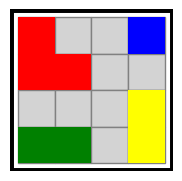

To a state incorporating the following block position(s):


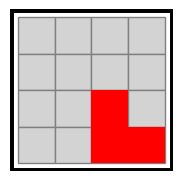

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


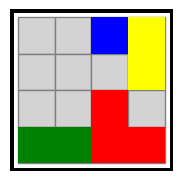

The action path to the solution is:
('red', 'right')
('red', 'down')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     2134  (includes start)
Nodes discarded by loop_check  =     1641  (493 distinct states added to queue)
Nodes tested (by goal_test)    =      356  (355 expanded + 1 goal)
Nodes left in queue            =      137

Time taken = 0.0677 seconds

Solve the following sliding blocks problem.
Get from this initial state:


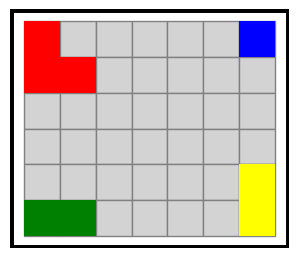

To a state incorporating the following block position(s):


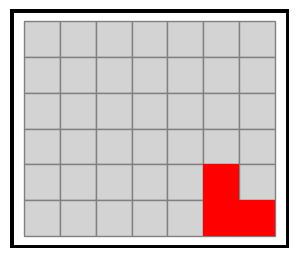

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


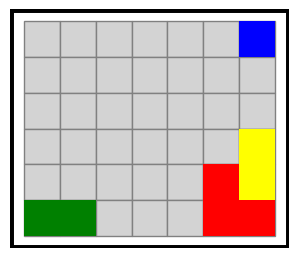

The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =   185417  (includes start)
Nodes discarded by loop_check  =   158676  (26741 distinct states added to queue)
Nodes tested (by goal_test)    =    16547  (16546 expanded + 1 goal)
Nodes left in queue            =    10194

Time taken = 6.1544 seconds



In [6]:
small_search = search( small_puzzle, 'BF/FIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_search = search( large_puzzle, 'BF/FIFO', 30000, loop_check=True, randomise=False, return_info=True)

This test is for Depth first search. The small gird passed successfully however, the larger grid did not so we increased the node limit to 35000 to see at what point it would pass.

Solve the following sliding blocks problem.
Get from this initial state:


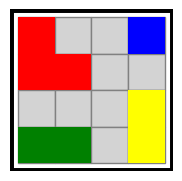

To a state incorporating the following block position(s):


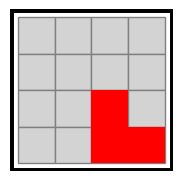

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 78
Goal state is:


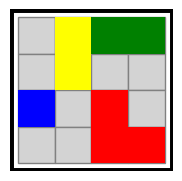

The action path to the solution is:
('yellow', 'up')
('yellow', 'left')
('yellow', 'up')
('green', 'up')
('green', 'right')
('green', 'right')
('green', 'down')
('yellow', 'down')
('yellow', 'right')
('blue', 'left')
('yellow', 'up')
('green', 'up')
('green', 'left')
('yellow', 'down')
('yellow', 'down')
('green', 'down')
('blue', 'down')
('yellow', 'up')
('yellow', 'up')
('green', 'left')
('green', 'up')
('yellow', 'down')
('yellow', 'down')
('yellow', 'left')
('green', 'down')
('blue', 'up')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('yellow', 'right')
('green', 'right')
('yellow', 'down')
('red', 'down')
('yellow', 'down')
('green', 'left')
('blue', 'down')
('yellow', 'up')
('yellow', 'up')
('yellow', 'left')
('green', 'right')
('yellow', 'down')
('green', 'right')
('yellow', 'right')
('yellow', 'up')
('green', 'up')
('yellow', 'left')
('blue', 'up')
('green', 'down')
('blue', 'left')
('yellow', 'down')
('yellow', 'right')
('red', 'down')
('yellow', 'up')
('green', 'up')
('

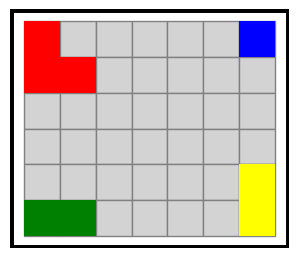

To a state incorporating the following block position(s):


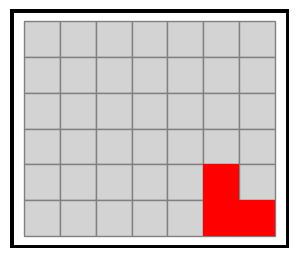

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
...
!! Search node limit (30000) reached !!
): No solution found :(


SEARCH SPACE STATS:
Total nodes generated          =    43931  (includes start)
Nodes discarded by loop_check  =    13930  (30001 distinct states added to queue)
Nodes tested (by goal_test)    =     3982  (all expanded)
Nodes left in queue            =    26018

Time taken = 3.7419 seconds

Solve the following sliding blocks problem.
Get from this initial state:


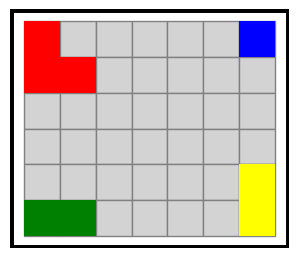

To a state incorporating the following block position(s):


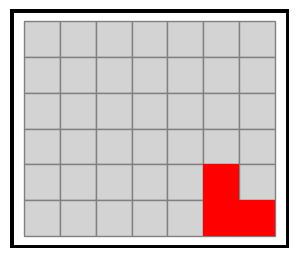

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 35000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 344
Goal state is:


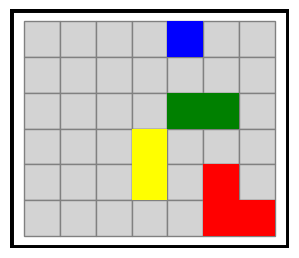

The action path to the solution is:
('blue', 'left')
('green', 'right')
('yellow', 'up')
('red', 'down')
('blue', 'right')
('yellow', 'down')
('red', 'down')
('red', 'down')
('blue', 'left')
('yellow', 'up')
('yellow', 'left')
('red', 'up')
('yellow', 'left')
('blue', 'down')
('yellow', 'down')
('blue', 'right')
('green', 'up')
('yellow', 'left')
('yellow', 'up')
('red', 'up')
('green', 'up')
('green', 'left')
('blue', 'down')
('red', 'up')
('yellow', 'up')
('yellow', 'up')
('green', 'up')
('blue', 'left')
('blue', 'left')
('red', 'right')
('blue', 'up')
('yellow', 'down')
('blue', 'up')
('red', 'right')
('green', 'up')
('blue', 'down')
('yellow', 'down')
('blue', 'down')
('yellow', 'left')
('blue', 'left')
('yellow', 'up')
('green', 'down')
('green', 'down')
('red', 'right')
('yellow', 'up')
('red', 'right')
('yellow', 'up')
('red', 'right')
('blue', 'up')
('green', 'down')
('green', 'down')
('green', 'right')
('yellow', 'down')
('red', 'left')
('green', 'up')
('yellow', 'left')
('blu

In [7]:
small_Df = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_DF = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=False, return_info=True)
large_DF2 = search( large_puzzle, 'DF/LIFO', 35000, loop_check=True, randomise=True, return_info=True)

This is the same as the depth first test but randomise is true

Solve the following sliding blocks problem.
Get from this initial state:


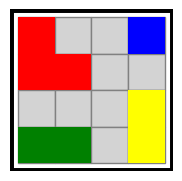

To a state incorporating the following block position(s):


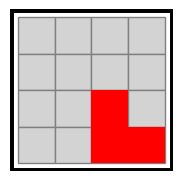

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 87
Goal state is:


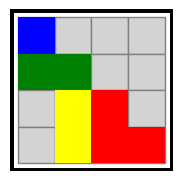

The action path to the solution is:
('red', 'right')
('green', 'up')
('yellow', 'up')
('red', 'left')
('green', 'right')
('yellow', 'down')
('blue', 'down')
('green', 'down')
('red', 'right')
('red', 'down')
('blue', 'up')
('yellow', 'up')
('red', 'up')
('blue', 'left')
('red', 'left')
('green', 'left')
('blue', 'left')
('yellow', 'left')
('red', 'down')
('green', 'right')
('yellow', 'right')
('green', 'right')
('red', 'down')
('yellow', 'left')
('yellow', 'left')
('green', 'up')
('blue', 'right')
('blue', 'right')
('yellow', 'up')
('yellow', 'left')
('red', 'right')
('blue', 'down')
('yellow', 'right')
('blue', 'left')
('red', 'left')
('yellow', 'left')
('green', 'left')
('blue', 'up')
('blue', 'left')
('green', 'right')
('green', 'down')
('blue', 'down')
('blue', 'down')
('yellow', 'right')
('blue', 'right')
('blue', 'right')
('blue', 'up')
('yellow', 'right')
('blue', 'up')
('yellow', 'down')
('red', 'up')
('red', 'up')
('blue', 'left')
('blue', 'left')
('yellow', 'up')
('red', 'dow

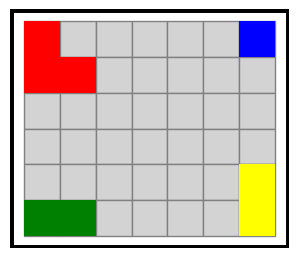

To a state incorporating the following block position(s):


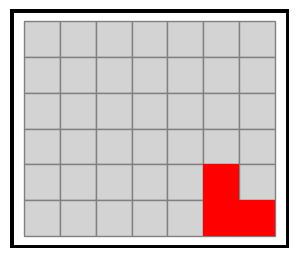

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=None, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 886
Goal state is:


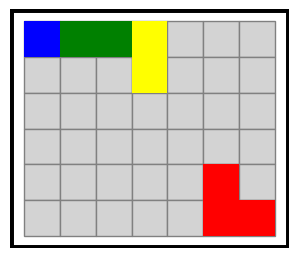

The action path to the solution is:
('red', 'down')
('green', 'right')
('yellow', 'up')
('yellow', 'up')
('yellow', 'up')
('green', 'up')
('blue', 'left')
('yellow', 'down')
('blue', 'left')
('green', 'right')
('yellow', 'down')
('yellow', 'left')
('red', 'down')
('green', 'right')
('yellow', 'right')
('yellow', 'down')
('blue', 'left')
('green', 'down')
('blue', 'down')
('yellow', 'up')
('green', 'right')
('yellow', 'up')
('green', 'up')
('green', 'left')
('red', 'down')
('green', 'down')
('yellow', 'up')
('blue', 'down')
('blue', 'right')
('green', 'up')
('yellow', 'down')
('yellow', 'down')
('green', 'up')
('red', 'up')
('red', 'right')
('green', 'down')
('green', 'right')
('red', 'right')
('green', 'up')
('yellow', 'up')
('blue', 'right')
('red', 'up')
('red', 'right')
('yellow', 'up')
('green', 'down')
('red', 'left')
('red', 'down')
('green', 'left')
('blue', 'down')
('yellow', 'up')
('yellow', 'left')
('blue', 'up')
('green', 'down')
('green', 'left')
('blue', 'left')
('green', 

In [8]:
small_DFR = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True)
large_DFR = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True)

We have no introduced the cost aspect of the search. This cost function is from Search Exercise 6

Solve the following sliding blocks problem.
Get from this initial state:


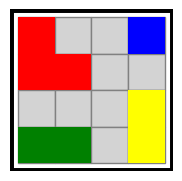

To a state incorporating the following block position(s):


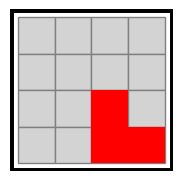

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=cost, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


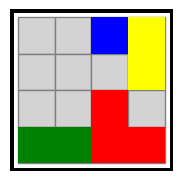

Cost of reaching goal: 7
The action path to the solution is:
('red', 'right')
('red', 'down')
('blue', 'left')
('yellow', 'up')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     2134  (includes start)
Nodes discarded by loop_check  =     1641  (493 distinct states added to queue)
Nodes tested (by goal_test)    =      356  (355 expanded + 1 goal)
Nodes left in queue            =      137

Time taken = 0.0723 seconds

Solve the following sliding blocks problem.
Get from this initial state:


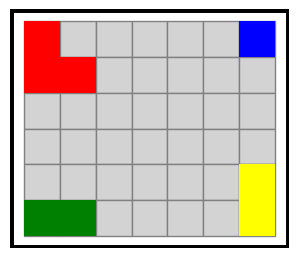

To a state incorporating the following block position(s):


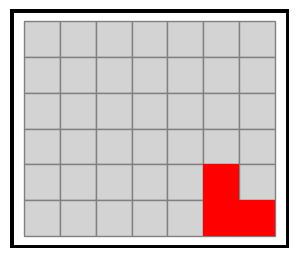

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=cost, heuristic=None
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
................
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


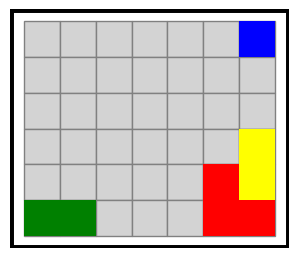

Cost of reaching goal: 10
The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =   185417  (includes start)
Nodes discarded by loop_check  =   158676  (26741 distinct states added to queue)
Nodes tested (by goal_test)    =    16547  (16546 expanded + 1 goal)
Nodes left in queue            =    10194

Time taken = 6.4592 seconds



In [9]:
def cost(path, state):
        return len(path)

small_cost = search(small_puzzle, 'BF/FIFO', 30000, cost=cost, loop_check=True, return_info=True)
large_cost = search(large_puzzle, 'BF/FIFO', 30000, cost=cost, loop_check=True, return_info=True)

This A* algorithm uses the cost function from before and now uses heuristics. This heuristic is from Search Exercise 7

Solve the following sliding blocks problem.
Get from this initial state:


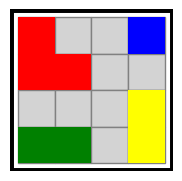

To a state incorporating the following block position(s):


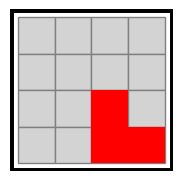

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_right_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)

:-)) *SUCCESS* ((-:

Path length = 7
Goal state is:


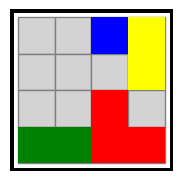

Cost of reaching goal: 7
The action path to the solution is:
('red', 'right')
('yellow', 'up')
('blue', 'left')
('red', 'down')
('yellow', 'up')
('red', 'right')
('red', 'down')


SEARCH SPACE STATS:
Total nodes generated          =     1190  (includes start)
Nodes discarded by loop_check  =      875  (315 distinct states added to queue)
Nodes tested (by goal_test)    =      201  (200 expanded + 1 goal)
Nodes left in queue            =      114

Time taken = 0.0525 seconds

Solve the following sliding blocks problem.
Get from this initial state:


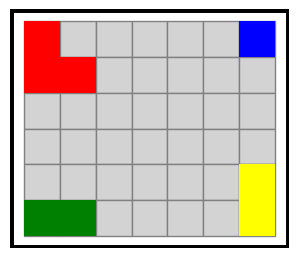

To a state incorporating the following block position(s):


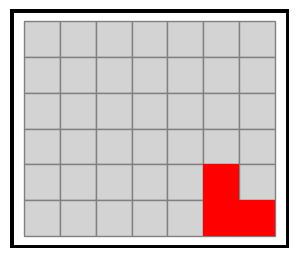

You need to slide the red block to cover the bottom right square.

** Running Brandon's Search Algorithm **
Strategy: mode=DF/LIFO, cost=cost, heuristic=red_right_heuristic
Max search nodes: 30000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:


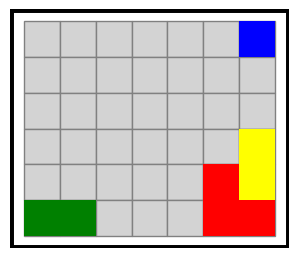

Cost of reaching goal: 10
The action path to the solution is:
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'right')
('red', 'down')
('red', 'down')
('red', 'down')
('yellow', 'up')
('red', 'down')
('red', 'right')


SEARCH SPACE STATS:
Total nodes generated          =    20189  (includes start)
Nodes discarded by loop_check  =    15888  (4301 distinct states added to queue)
Nodes tested (by goal_test)    =     1929  (1928 expanded + 1 goal)
Nodes left in queue            =     2372

Time taken = 0.8055 seconds



In [10]:
def red_right_heuristic(state):
    for row in state.blockstate:
      for i, col in enumerate(row):
          if col == 1:
            return 6-i

small_A = search( small_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_right_heuristic)
large_A = search( large_puzzle, 'DF/LIFO', 30000, loop_check=True, randomise=True, return_info=True, cost=cost, heuristic=red_right_heuristic)


This table shows a summary of every test that was just performed and it is from Search Exercise 7. From the results, all the large tests failed with the low node limit of 5000.

In [11]:
TEST_RESULTS =[small_search, large_search, small_Df, large_DF, large_DF2, small_DFR, large_DFR,small_A, large_A]

# Specify symbols for termination conditions:
short_tc = {"GOAL_STATE_FOUND"     : "Y",
            "NODE_LIMIT_EXCEEDED"  : "!",
            "SEARH-SPACE_EXHAUSTED": "x"}

print("\n                **TESTS SUMMARY**\n")

print("Test    #max   Result   #gen     #inQ    Time s")
for i, test in enumerate(TEST_RESULTS):
    max  = test['args']['max_nodes']
    tc  = test['result']['termination_condition']
    stc = short_tc[tc]

    ng  = test['search_stats']['nodes_generated']
    nq  = test['search_stats']['nodes_left_in_queue']
    time = round( test['search_stats']['time_taken'], 2 )
    print( f"{i:>3}: {max:>8}    {stc}  {ng:>8} {nq:>8}     {time} ")


                **TESTS SUMMARY**

Test    #max   Result   #gen     #inQ    Time s
  0:    30000    Y      2134      137     0.07 
  1:    30000    Y    185417    10194     6.15 
  2:    30000    Y       472      192     0.04 
  3:    30000    !     43931    26018     3.74 
  4:    35000    Y      3768     2740     1.02 
  5:    30000    Y       550      239     0.11 
  6:    30000    Y      9950     7227     0.62 
  7:    30000    Y      1190      114     0.05 
  8:    30000    Y     20189     2372     0.81 


Part B

In [ ]:
# class Robot:
#     def __init__(self, location, carried_parcels):
#         self.location = location
#         self.carried_parcels = carried_parcels

#     ## Define unique string representation for the state of the robot object
#     def __repr__(self):
#         return str( ( self.location,
#                       self.carried_parcels) )

# class Door:
#     def __init__(self, conveyorA ,conveyorB, conveyorC, storage, full=False):
#         self.goes_between = {conveyorA, conveyorB, conveyorC, storage}
#         self.full = full
#         # Define handy dictionary to get room on other side of a door
#         self.other_loc = {conveyorA:conveyorB, conveyorB:conveyorA, conveyorA:storage, storage:conveyorA, storage:conveyorB, conveyorB:storage}

#     ## Define a unique string representation for a door object
#     def __repr__(self):
#         return str( ("door", self.goes_between, self.full) )

In [ ]:
# class State:
#     def __init__( self, robot, doors, room_contents ):
#         self.robot = robot
#         self.doors = doors
#         self.room_contents = room_contents

#     ## Define a string representation that will be uniquely identify the state.
#     ## An easy way is to form a tuple of representations of the components of
#     ## the state, then form a string from that:
#     def __repr__(self):
#         return str( ( self.robot.__repr__(),
#                       [d.__repr__() for d in self.doors],
#                       self.room_contents ) )

# class Conveyor:
#     def __init__(self,capacity):
#         self.capacity = capacity

#     def __repr__(self):
#         return str()


In [ ]:
# DOORS = [
#     Door('workshop', 'store room' ),
#     Door( 'store room', 'tool cupboard', doorkey='rusty key', locked=False )
# ]


In [ ]:
# from copy import deepcopy

# class RobotWorker( SearchProblem ):

#     def __init__( self, state, goal_item_locations ):
#         self.initial_state = state
#         self.goal_item_locations = goal_item_locations

#     def possible_actions( self, state ):

#         robot_location = state.robot.location
#         strength       = state.robot.strength
#         weight_carried = state.robot.weight_carried()

#         actions = []
#         # Can put down any carried item
#         for i in state.robot.carried_items:
#             actions.append( ("put down", i) )

#         # Can pick up any item in room if strong enough
#         for i in state.room_contents[robot_location]:
#             if strength >= weight_carried + ITEM_WEIGHT[i]:
#                 actions.append( ("pick up", i))

#         # If there is an unlocked door between robot location and
#         # another location can move to that location
#         for door in state.doors:
#             if  door.locked==False and robot_location in door.goes_between:
#                 actions.append( ("move to", door.other_loc[robot_location]) )

#         # Now the actions list should contain all possible actions
#         return actions

#     def successor( self, state, action):
#         next_state = deepcopy(state)
#         act, target = action
#         if act== "put down":
#             next_state.robot.carried_items.remove(target)
#             next_state.room_contents[state.robot.location].add(target)

#         if act == "pick up":
#             next_state.robot.carried_items.append(target)
#             next_state.room_contents[state.robot.location].remove(target)

#         if act == "move to":
#             next_state.robot.location = target

#         return next_state

#     def goal_test(self, state):
#         #print(state.room_contents)
#         for room, contents in self.goal_item_locations.items():
#             for i in contents:
#                 if not i in state.room_contents[room]:
#                     return False
#         return True

#     def display_state(self,state):
#         print("Robot location:", state.robot.location)
#         print("Robot carrying:", state.robot.carried_items)
#         print("Room contents:", state.room_contents)

In [ ]:
# rob = Robot('store room', [], 15 )

# state = State(rob, DOORS, ROOM_CONTENTS)

# goal_item_locations =  {"store room":{"sledge hammer", "screwdriver", "anvil"}}

# RW_PROBLEM_1 = RobotWorker( state, goal_item_locations )

In [ ]:
# poss_acts = RW_PROBLEM_1.possible_actions( RW_PROBLEM_1.initial_state )
# poss_acts

[('pick up', 'suitcase'),
 ('pick up', 'bucket'),
 ('move to', 'workshop'),
 ('move to', 'tool cupboard')]

In [ ]:
# for act in poss_acts:
#     print("Action", act, "leads to the following state:")
#     next_state = RW_PROBLEM_1.successor( RW_PROBLEM_1.initial_state, act )
#     RW_PROBLEM_1.display_state(next_state)
#     print()

Action ('pick up', 'suitcase') leads to the following state:
Robot location: store room
Robot carrying: ['suitcase']
Room contents: {'workshop': {'rusty key'}, 'store room': {'bucket'}, 'tool cupboard': {'saw', 'sledge hammer', 'anvil', 'screwdriver'}}

Action ('pick up', 'bucket') leads to the following state:
Robot location: store room
Robot carrying: ['bucket']
Room contents: {'workshop': {'rusty key'}, 'store room': {'suitcase'}, 'tool cupboard': {'saw', 'sledge hammer', 'anvil', 'screwdriver'}}

Action ('move to', 'workshop') leads to the following state:
Robot location: workshop
Robot carrying: []
Room contents: {'workshop': {'rusty key'}, 'store room': {'suitcase', 'bucket'}, 'tool cupboard': {'saw', 'sledge hammer', 'anvil', 'screwdriver'}}

Action ('move to', 'tool cupboard') leads to the following state:
Robot location: tool cupboard
Robot carrying: []
Room contents: {'workshop': {'rusty key'}, 'store room': {'suitcase', 'bucket'}, 'tool cupboard': {'saw', 'sledge hammer', 'a

In [ ]:
# search( RW_PROBLEM_1, 'BF/FIFO', 100000, loop_check=True)

This is the general SearchProblem parent class
You must extend this class to encode a particular search problem.

** Running Brandon's Search Algorithm **
Strategy: mode=BF/FIFO, cost=None, heuristic=None
Max search nodes: 100000  (max number added to queue)
Searching (will output '.' each 1000 goal_tests)
.....................
:-)) *SUCCESS* ((-:

Path length = 10
Goal state is:
Robot location: store room
Robot carrying: []
Room contents: {'workshop': {'rusty key'}, 'store room': {'suitcase', 'screwdriver', 'anvil', 'bucket', 'sledge hammer'}, 'tool cupboard': {'saw'}}
The action path to the solution is:
    ('move to', 'tool cupboard')
    ('pick up', 'sledge hammer')
    ('pick up', 'screwdriver')
    ('move to', 'store room')
    ('put down', 'sledge hammer')
    ('put down', 'screwdriver')
    ('move to', 'tool cupboard')
    ('pick up', 'anvil')
    ('move to', 'store room')
    ('put down', 'anvil')


SEARCH SPACE STATS:
Total nodes generated          =   113001  (includes start

'GOAL_STATE_FOUND'

In [9]:
from copy import deepcopy
from datetime import datetime

class Parcel:
    def __init__(self, parcel_id, date, priority):
        self.parcel_id = parcel_id
        self.date = date
        self.priority = priority

    def __repr__(self):
        return str((self.parcel_id, self.date, self.priority))

    def __eq__(self, other):
        return (self.parcel_id, self.date, self.priority) == (other.parcel_id, other.date, other.priority)

    def __hash__(self):
        return hash((self.parcel_id, self.date, self.priority))

class Robot:
    def __init__(self, location, carried_items):
        self.location = location
        self.carried_items = carried_items

    def __repr__(self):
        return str((self.location, [item.__repr__() for item in self.carried_items]))

class ConveyorBelt:
    def __init__(self, name):
        self.name = name
        self.items = []
        self.capacity = 100  # Start with 100% capacity

    def __repr__(self):
        return str((self.name, [item.__repr__() for item in self.items], self.capacity))

class State:
    def __init__(self, robot, conveyor_belts, storage_room):
        self.robot = robot
        self.conveyor_belts = conveyor_belts
        self.storage_room = storage_room

    def __repr__(self):
        return str((self.robot.__repr__(), [cb.__repr__() for cb in self.conveyor_belts], [item.__repr__() for item in self.storage_room]))

# Example parcels
STORAGE_ROOM = {
    Parcel('parcel1', datetime.now().strftime('%Y-%m-%d'), 1),
    Parcel('parcel2', datetime.now().strftime('%Y-%m-%d'), 2),
    Parcel('parcel3', datetime.now().strftime('%Y-%m-%d'), 1)
}

CONVEYOR_BELTS = [
    ConveyorBelt('conveyorA'),
    ConveyorBelt('conveyorB'),
    ConveyorBelt('conveyorC')
]

class RobotWorker(SearchProblem):
    def __init__(self, state, goal_item_locations):
        self.initial_state = state
        self.goal_item_locations = goal_item_locations

    def possible_actions(self, state):
        robot_location = state.robot.location

        actions = []
        if robot_location == 'storage room':
            for i in state.storage_room:
                actions.append(("pick up", i))

        if robot_location.startswith('conveyor'):
            for i in state.robot.carried_items:
                actions.append(("drop off", i))

        for cb in state.conveyor_belts:
            actions.append(("move to", cb.name))
        actions.append(("move to", 'storage room'))

        return actions

    def successor(self, state, action):
        next_state = deepcopy(state)
        act, target = action
        if act == "pick up":
            next_state.robot.carried_items.append(target)
            next_state.storage_room.remove(target)

        if act == "drop off":
            next_state.robot.carried_items.remove(target)
            for cb in next_state.conveyor_belts:
                if cb.name == state.robot.location:
                    cb.items.append(target)
                    cb.capacity -= 10  # Reduce capacity by 10% for each parcel

        if act == "move to":
            next_state.robot.location = target

        return next_state

    def goal_test(self, state):
        for cb_name, items in self.goal_item_locations.items():
            for cb in state.conveyor_belts:
                if cb.name == cb_name:
                    for item in items:
                        if item not in cb.items:
                            return False
        return True

    def display_state(self, state):
        print("Robot location:", state.robot.location)
        print("Robot carrying:", [item.__repr__() for item in state.robot.carried_items])
        print("Storage room contents:", [item.__repr__() for item in state.storage_room])
        for cb in state.conveyor_belts:
            print(f"{cb.name} contents:", [item.__repr__() for item in cb.items], "Capacity:", cb.capacity, "%")

rob = Robot('storage room', [])
state = State(rob, CONVEYOR_BELTS, STORAGE_ROOM)
goal_item_locations = {
    "conveyorA": {Parcel('parcel1', datetime.now().strftime('%Y-%m-%d'), 1)},
    "conveyorB": {Parcel('parcel2', datetime.now().strftime('%Y-%m-%d'), 2)},
    "conveyorC": {Parcel('parcel3', datetime.now().strftime('%Y-%m-%d'), 1)}
}
RW_PROBLEM_1 = RobotWorker(state, goal_item_locations)

poss_acts = RW_PROBLEM_1.possible_actions(RW_PROBLEM_1.initial_state)
for act in poss_acts:
    print("Action", act, "leads to the following state:")
    next_state = RW_PROBLEM_1.successor(RW_PROBLEM_1.initial_state, act)
    RW_PROBLEM_1.display_state(next_state)
    print()

Action ('pick up', ('parcel2', '2025-02-18', 2)) leads to the following state:
Robot location: storage room
Robot carrying: ["('parcel2', '2025-02-18', 2)"]
Storage room contents: ["('parcel1', '2025-02-18', 1)", "('parcel3', '2025-02-18', 1)"]
conveyorA contents: [] Capacity: 100 %
conveyorB contents: [] Capacity: 100 %
conveyorC contents: [] Capacity: 100 %

Action ('pick up', ('parcel1', '2025-02-18', 1)) leads to the following state:
Robot location: storage room
Robot carrying: ["('parcel1', '2025-02-18', 1)"]
Storage room contents: ["('parcel2', '2025-02-18', 2)", "('parcel3', '2025-02-18', 1)"]
conveyorA contents: [] Capacity: 100 %
conveyorB contents: [] Capacity: 100 %
conveyorC contents: [] Capacity: 100 %

Action ('pick up', ('parcel3', '2025-02-18', 1)) leads to the following state:
Robot location: storage room
Robot carrying: ["('parcel3', '2025-02-18', 1)"]
Storage room contents: ["('parcel2', '2025-02-18', 2)", "('parcel1', '2025-02-18', 1)"]
conveyorA contents: [] Capaci